![cover image](cover.jpg)

# Problem Framing

To develop a predictive model that forecasts the outcomes of sports events or gaming matches
based on historical data, player statistics, and other relevant factors. The model can be used to
inform betting strategies and improve user engagement on the platform.

- The project will be scoped to VALORANT, particularly its esports matches (VCT)
- Data is ranges from the years 2021 to 2024
- The predictive model will be primarily focused on predicting the outcomes (win/loss) of individual games (by map)
- Optionally, the model could also predict the scoreboard of the game (high-risk bets)
- To simulate a betting environment, the model will be used to predict the game outcomes from Champions 2024 matches

# Data Collection

The dataset used in this project was the [Valorant Champion Tour 2021-2024 Data](https://www.kaggle.com/datasets/ryanluong1/valorant-champion-tour-2021-2023-data/data), which was sourced from Kaggle and created by Ryan Luong. We chose this dataset because it included the most comprehensive statistics we found that are crucial for predictive analytics.

The dataset includes matches, agents, and player data from VCT 2021–2024. This was obtained via data scraping from [vlr.gg](https://www.vlr.gg/). Each year contains four folders: `agents`, `matches`, `player_stats`, and `ids`.

The `agents` folder contains agent pick rates, map pick rates, attacker and defender side win/loss percentage, team pick rates on an agent, and win/loss rate.

The `matches folder` contains team picks and bans, their economy on each round of a match, their economy stats on a match, players kills performance on other players, players kill stats, maps that were played on a match, the scores from the map, players overview stats, a player kills performance on players and their agent on a specific round, matches scores and their results, a list of abbreviated team names with their full names, the count of the method that occurred for a team for a match they played and its round number.

The `player_stats` folder only contains player stats.

The `ids` folder contains the ids for the teams, players, tournaments, stages, match types, matches, and games.

The `all_ids` folder contains all the IDs, and the abbreviated team name with their full name.

# Loading the Data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To avoid truncating the output
pd.set_option('display.max_rows', None)

In [6]:
# VCT 2021
matches_overview_2021 = pd.read_csv("vct_data/vct_2021/matches/overview.csv")
matches_maps_scores_2021 = pd.read_csv("vct_data/vct_2021/matches/maps_scores.csv")
matches_eco_rounds_2021 = pd.read_csv("vct_data/vct_2021/matches/eco_rounds.csv")
matches_kills_stats_2021 = pd.read_csv("vct_data/vct_2021/matches/kills_stats.csv")
matches_win_loss_methods_count_2021 = pd.read_csv("vct_data/vct_2021/matches/win_loss_methods_count.csv")

# VCT 2022
matches_overview_2022 = pd.read_csv("vct_data/vct_2022/matches/overview.csv")
matches_maps_scores_2022 = pd.read_csv("vct_data/vct_2022/matches/maps_scores.csv")
matches_eco_rounds_2022 = pd.read_csv("vct_data/vct_2022/matches/eco_rounds.csv")
matches_kills_stats_2022 = pd.read_csv("vct_data/vct_2022/matches/kills_stats.csv")
matches_win_loss_methods_count_2022 = pd.read_csv("vct_data/vct_2022/matches/win_loss_methods_count.csv")

# VCT 2023
matches_overview_2023 = pd.read_csv("vct_data/vct_2023/matches/overview.csv")
matches_maps_scores_2023 = pd.read_csv("vct_data/vct_2023/matches/maps_scores.csv")
matches_eco_rounds_2023 = pd.read_csv("vct_data/vct_2023/matches/eco_rounds.csv")
matches_kills_stats_2023 = pd.read_csv("vct_data/vct_2023/matches/kills_stats.csv")
matches_win_loss_methods_count_2023 = pd.read_csv("vct_data/vct_2023/matches/win_loss_methods_count.csv")

# VCT 2024
matches_overview_2024 = pd.read_csv("vct_data/vct_2024/matches/overview.csv")
matches_maps_scores_2024 = pd.read_csv("vct_data/vct_2024/matches/maps_scores.csv")
matches_eco_rounds_2024 = pd.read_csv("vct_data/vct_2024/matches/eco_rounds.csv")
matches_kills_stats_2024 = pd.read_csv("vct_data/vct_2024/matches/kills_stats.csv")
matches_win_loss_methods_count_2024 = pd.read_csv("vct_data/vct_2024/matches/win_loss_methods_count.csv")

# For mapping ids to names
all_ids_all_teams_ids = pd.read_csv("vct_data/all_ids/all_teams_ids.csv")
all_ids_all_matches_games_ids = pd.read_csv("vct_data/all_ids/all_matches_games_ids.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_13780\4245639922.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  matches_overview_2021 = pd.read_csv("vct_data/vct_2021/matches/overview.csv")


# Data Cleaning and Preprocessing

- ~~Load data~~
- ~~For each year, figure out how to join the tables horizontally and which columns to keep~~
- ~~Concatenate 2021-2024 data~~
- Handle missing data (prioritize imputation)
- Encode categorical data to numerical (e.g., one-hot, ordinal)
- Feature engineering
- Normalization and standardization (if necessary)

Variable naming convention: `folder_filename_year`

## Merging and concatenating tables to form a single dataset

In [7]:
def merge_tables(
        matches_maps_scores, 
        matches_overview, 
        matches_eco_rounds, 
        matches_kills_stats,
        matches_win_loss_methods_count,
        all_ids_all_teams_ids,
        all_ids_all_matches_games_ids
    ):

    # Map ids to their corresponding column names
    vct_data = matches_maps_scores.merge(
        all_ids_all_matches_games_ids,
        on=["Tournament", "Stage", "Match Type", "Match Name", "Map"],
        how="left"
    )

    vct_data = vct_data.merge(all_ids_all_teams_ids, left_on="Team A", right_on="Team", how="left")
    vct_data = vct_data.merge(all_ids_all_teams_ids, left_on="Team B", right_on="Team", how="left", suffixes=("_TeamA", "_TeamB"))

    # Always drop these columns after merging for Team B to avoid duplicate col error
    vct_data = vct_data.drop(columns=["Team_TeamA", "Team_TeamB"])

    # Aggregate and merge overview stats
    matches_overview_both = matches_overview[matches_overview["Side"] == "both"]

    overview_agg = matches_overview_both.groupby(["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team"]).agg({
        "Rating": "mean",
        "Average Combat Score": "mean",
        "Kills": "mean",
        "Deaths": "mean",
        "Assists": "mean",
        "Kills - Deaths (KD)": "mean",
        "Kill, Assist, Trade, Survive %": lambda x: np.mean([(float(i.strip("%")) / 100) if isinstance(i, str) else i for i in x]),
        "Average Damage Per Round": "mean",
        "Headshot %": lambda x: np.mean([(float(i.strip("%")) / 100) if isinstance(i, str) else i for i in x]),
        "First Kills": "mean",
        "First Deaths": "mean",
        "Kills - Deaths (FKD)": "mean"
    }).reset_index()

    vct_data = vct_data.merge(
        overview_agg, 
        left_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team A"],
        right_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team"],
        how="left"
    )

    vct_data = vct_data.merge(
        overview_agg, 
        left_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team B"],
        right_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team"],
        how="left",
        suffixes=("_TeamA", "_TeamB")
    )

    vct_data = vct_data.drop(columns=["Team_TeamA", "Team_TeamB"])

    # Aggregate and merge for eco rounds
    eco_rounds_agg = matches_eco_rounds.groupby(["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team"]).agg({
        "Loadout Value": lambda x: np.mean([float(i.replace('k', '').replace(',', '')) * 1000 for i in x]),
        "Remaining Credits": lambda x: np.mean([float(i.replace('k', '').replace(',', '')) * 1000 for i in x]),
        "Type": lambda x: x.mode()[0]
    }).reset_index()

    vct_data = vct_data.merge(
        eco_rounds_agg,
        left_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team A"],
        right_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team"],
        how="left"
    )

    vct_data = vct_data.merge(
        eco_rounds_agg,
        left_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team B"],
        right_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team"],
        how="left",
        suffixes=("_TeamA", "_TeamB")
    )

    vct_data = vct_data.drop(columns=["Team_TeamA", "Team_TeamB"])

    # Aggregate and merge for kills stats
    kills_stats_agg = matches_kills_stats.groupby(["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team"]).agg({
        "2k": "sum",
        "3k": "sum",
        "4k": "sum",
        "5k": "sum",
        "1v1": "sum",
        "1v2": "sum",
        "1v3": "sum",
        "1v4": "sum",
        "1v5": "sum",
        "Econ": "mean",
        "Spike Plants": "sum",
        "Spike Defuses": "sum"
    }).reset_index()

    vct_data = vct_data.merge(
        kills_stats_agg,
        left_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team A"],
        right_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team"],
        how="left"
    )

    vct_data = vct_data.merge(
        kills_stats_agg,
        left_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team B"],
        right_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team"],
        how="left",
        suffixes=("_TeamA", "_TeamB")
    )

    vct_data = vct_data.drop(columns=["Team_TeamA", "Team_TeamB"])
    
    # Merge with win/loss methods count
    vct_data = vct_data.merge(
        matches_win_loss_methods_count,
        left_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team A"],
        right_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team"],
        how="left"
    )

    vct_data = vct_data.merge(
        matches_win_loss_methods_count,
        left_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team B"],
        right_on=["Tournament", "Stage", "Match Type", "Match Name", "Map", "Team"],
        how="left",
        suffixes=("_TeamA", "_TeamB")
    )

    vct_data = vct_data.drop(columns=["Team_TeamA", "Team_TeamB"])

    return vct_data

In [8]:
vct_2021 = merge_tables(
    matches_maps_scores_2021, 
    matches_overview_2021, 
    matches_eco_rounds_2021, 
    matches_kills_stats_2021, 
    matches_win_loss_methods_count_2021,
    all_ids_all_teams_ids,
    all_ids_all_matches_games_ids
)

vct_2022 = merge_tables(
    matches_maps_scores_2022, 
    matches_overview_2022, 
    matches_eco_rounds_2022, 
    matches_kills_stats_2022, 
    matches_win_loss_methods_count_2022,
    all_ids_all_teams_ids,
    all_ids_all_matches_games_ids
)

vct_2023 = merge_tables(
    matches_maps_scores_2023, 
    matches_overview_2023, 
    matches_eco_rounds_2023, 
    matches_kills_stats_2023, 
    matches_win_loss_methods_count_2023,
    all_ids_all_teams_ids,
    all_ids_all_matches_games_ids
)

vct_2024 = merge_tables(
    matches_maps_scores_2024, 
    matches_overview_2024, 
    matches_eco_rounds_2024, 
    matches_kills_stats_2024, 
    matches_win_loss_methods_count_2024,
    all_ids_all_teams_ids,
    all_ids_all_matches_games_ids
)

Investigating each year's VCT data

In [9]:
vct_2021.head()

,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team A Attacker Score,Team A Defender Score,Team A Overtime Score,...,Detonation Denied_TeamA,Time Expiry (Failed to Plant)_TeamA,Elimination_TeamB,Detonated_TeamB,Defused_TeamB,Time Expiry (No Plant)_TeamB,Eliminated_TeamB,Defused Failed_TeamB,Detonation Denied_TeamB,Time Expiry (Failed to Plant)_TeamB
0,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Haven,Vision Strikers,13,9,4,NaN,...,1.0,0.0,4.0,0.0,1.0,0.0,9.0,2.0,2.0,0.0
1,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Breeze,Vision Strikers,13,9,4,NaN,...,2.0,0.0,3.0,0.0,2.0,0.0,9.0,3.0,1.0,0.0
2,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Icebox,Team Vikings,13,6,7,NaN,...,5.0,1.0,2.0,1.0,5.0,1.0,7.0,2.0,3.0,1.0
3,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Haven,Team Vikings,13,6,7,NaN,...,1.0,0.0,5.0,2.0,1.0,0.0,11.0,0.0,2.0,0.0
4,Valorant Champions 2021,Group Stage,Opening (D),FNATIC vs Cloud9,Icebox,FNATIC,13,7,6,NaN,...,4.0,0.0,6.0,1.0,4.0,0.0,7.0,0.0,6.0,0.0


In [10]:
vct_2022.head()

,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team A Attacker Score,Team A Defender Score,Team A Overtime Score,...,Detonation Denied_TeamA,Time Expiry (Failed to Plant)_TeamA,Elimination_TeamB,Detonated_TeamB,Defused_TeamB,Time Expiry (No Plant)_TeamB,Eliminated_TeamB,Defused Failed_TeamB,Detonation Denied_TeamB,Time Expiry (Failed to Plant)_TeamB
0,Valorant Champions 2022,Group Stage,Opening (A),Paper Rex vs EDward Gaming,Pearl,Paper Rex,13,6,7,NaN,...,3.0,0.0,7.0,1.0,3.0,0.0,11.0,0.0,1.0,1.0
1,Valorant Champions 2022,Group Stage,Opening (A),Paper Rex vs EDward Gaming,Icebox,Paper Rex,5,2,3,NaN,...,0.0,0.0,11.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0
2,Valorant Champions 2022,Group Stage,Opening (A),Paper Rex vs EDward Gaming,Haven,Paper Rex,13,7,6,NaN,...,1.0,1.0,5.0,1.0,1.0,1.0,9.0,1.0,3.0,0.0
3,Valorant Champions 2022,Group Stage,Opening (A),Leviatán vs Team Liquid,Haven,Leviatán,13,8,5,NaN,...,2.0,1.0,6.0,1.0,2.0,1.0,8.0,0.0,5.0,0.0
4,Valorant Champions 2022,Group Stage,Opening (A),Leviatán vs Team Liquid,Ascent,Leviatán,13,6,7,NaN,...,2.0,1.0,6.0,1.0,2.0,1.0,7.0,4.0,2.0,0.0


In [11]:
vct_2023.head()

,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team A Attacker Score,Team A Defender Score,Team A Overtime Score,...,Detonation Denied_TeamA,Time Expiry (Failed to Plant)_TeamA,Elimination_TeamB,Detonated_TeamB,Defused_TeamB,Time Expiry (No Plant)_TeamB,Eliminated_TeamB,Defused Failed_TeamB,Detonation Denied_TeamB,Time Expiry (Failed to Plant)_TeamB
0,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Fracture,Team Liquid,11,6,5,NaN,...,1,1,6,5,1,1,8,2,1,0
1,Valorant Champions 2023,Group Stage,Opening (D),Team Liquid vs Natus Vincere,Bind,Team Liquid,15,7,5,3.0,...,4,1,11,1,4,1,11,1,2,1
2,Valorant Champions 2023,Group Stage,Opening (D),DRX vs LOUD,Lotus,DRX,13,7,5,1.0,...,4,1,8,2,4,1,5,4,3,1
3,Valorant Champions 2023,Group Stage,Opening (D),DRX vs LOUD,Split,DRX,13,8,5,NaN,...,2,0,2,2,2,0,8,2,1,2
4,Valorant Champions 2023,Group Stage,Opening (D),DRX vs LOUD,Ascent,DRX,13,8,5,NaN,...,2,0,6,0,2,0,9,1,3,0


In [12]:
vct_2024.head()

,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team A Attacker Score,Team A Defender Score,Team A Overtime Score,...,Detonation Denied_TeamA,Time Expiry (Failed to Plant)_TeamA,Elimination_TeamB,Detonated_TeamB,Defused_TeamB,Time Expiry (No Plant)_TeamB,Eliminated_TeamB,Defused Failed_TeamB,Detonation Denied_TeamB,Time Expiry (Failed to Plant)_TeamB
0,Champions Tour 2024: Americas Stage 2,Regular Season,Week 1,MIBR vs Leviatán,Ascent,MIBR,9,6,3,NaN,...,1,0,11,1,1,0,8,0,1,0
1,Champions Tour 2024: Americas Stage 2,Regular Season,Week 1,MIBR vs Leviatán,Icebox,MIBR,7,3,4,NaN,...,4,0,8,1,4,0,4,2,1,0
2,Champions Tour 2024: Americas Stage 2,Regular Season,Week 1,Sentinels vs NRG Esports,Lotus,Sentinels,13,8,5,NaN,...,3,0,3,2,3,0,10,1,2,0
3,Champions Tour 2024: Americas Stage 2,Regular Season,Week 1,Sentinels vs NRG Esports,Sunset,Sentinels,14,9,3,2.0,...,2,0,7,3,2,0,11,2,1,0
4,Champions Tour 2024: Americas Stage 2,Regular Season,Week 1,FURIA vs 100 Thieves,Icebox,FURIA,14,6,6,2.0,...,1,0,10,1,1,0,11,0,2,1


Concatenating yearly data into one

In [13]:
vct_2021_2024 = pd.concat([vct_2021, vct_2022, vct_2023, vct_2024])

In [14]:
vct_2021_2024.head()

,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team A Attacker Score,Team A Defender Score,Team A Overtime Score,...,Detonation Denied_TeamA,Time Expiry (Failed to Plant)_TeamA,Elimination_TeamB,Detonated_TeamB,Defused_TeamB,Time Expiry (No Plant)_TeamB,Eliminated_TeamB,Defused Failed_TeamB,Detonation Denied_TeamB,Time Expiry (Failed to Plant)_TeamB
0,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Haven,Vision Strikers,13,9,4,NaN,...,1.0,0.0,4.0,0.0,1.0,0.0,9.0,2.0,2.0,0.0
1,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Breeze,Vision Strikers,13,9,4,NaN,...,2.0,0.0,3.0,0.0,2.0,0.0,9.0,3.0,1.0,0.0
2,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Icebox,Team Vikings,13,6,7,NaN,...,5.0,1.0,2.0,1.0,5.0,1.0,7.0,2.0,3.0,1.0
3,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Haven,Team Vikings,13,6,7,NaN,...,1.0,0.0,5.0,2.0,1.0,0.0,11.0,0.0,2.0,0.0
4,Valorant Champions 2021,Group Stage,Opening (D),FNATIC vs Cloud9,Icebox,FNATIC,13,7,6,NaN,...,4.0,0.0,6.0,1.0,4.0,0.0,7.0,0.0,6.0,0.0


In [15]:
vct_2021_2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27022 entries, 0 to 1165
Data columns (total 94 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Tournament                            27022 non-null  object 
 1   Stage                                 27022 non-null  object 
 2   Match Type                            27022 non-null  object 
 3   Match Name                            27022 non-null  object 
 4   Map                                   26979 non-null  object 
 5   Team A                                27022 non-null  object 
 6   Team A Score                          27022 non-null  int64  
 7   Team A Attacker Score                 27022 non-null  int64  
 8   Team A Defender Score                 27022 non-null  int64  
 9   Team A Overtime Score                 2407 non-null   float64
 10  Team B                                27022 non-null  object 
 11  Team B Score         

In [16]:
vct_2021_2024.describe()

,Team A Score,Team A Attacker Score,Team A Defender Score,Team A Overtime Score,Team B Score,Team B Attacker Score,Team B Defender Score,Team B Overtime Score,Tournament ID,Stage ID,...,Detonation Denied_TeamA,Time Expiry (Failed to Plant)_TeamA,Elimination_TeamB,Detonated_TeamB,Defused_TeamB,Time Expiry (No Plant)_TeamB,Eliminated_TeamB,Defused Failed_TeamB,Detonation Denied_TeamB,Time Expiry (Failed to Plant)_TeamB
count,27022.000000,27022.000000,27022.000000,2407.000000,27022.000000,27022.000000,27021.000000,2407.000000,26983.000000,26983.00000,...,26984.000000,26984.000000,26984.000000,26984.000000,26984.000000,26984.000000,26984.000000,26984.000000,26984.00000,26984.000000
mean,10.734587,6.417475,4.119865,2.045285,9.486011,3.761750,5.536435,1.945160,680.025498,1355.06556,...,1.904425,0.205752,6.686147,0.681626,1.904425,0.205752,7.705640,0.721687,2.05544,0.241699
std,3.646161,2.737558,2.306665,1.746397,4.151297,2.462209,2.729987,1.724688,390.273136,747.77649,...,1.555750,0.482341,3.399158,0.920029,1.555750,0.482341,3.240275,0.953654,1.57048,0.518553
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,277.000000,554.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,8.000000,4.000000,2.000000,1.000000,6.000000,2.000000,3.000000,0.000000,375.000000,779.00000,...,1.000000,0.000000,4.000000,0.000000,1.000000,0.000000,5.000000,0.000000,1.00000,0.000000
50%,13.000000,7.000000,4.000000,2.000000,11.000000,4.000000,5.000000,2.000000,557.000000,1125.00000,...,2.000000,0.000000,7.000000,0.000000,2.000000,0.000000,8.000000,0.000000,2.00000,0.000000
75%,13.000000,9.000000,6.000000,3.000000,13.000000,6.000000,8.000000,3.000000,840.000000,1670.50000,...,3.000000,0.000000,9.000000,1.000000,3.000000,0.000000,10.000000,1.000000,3.00000,0.000000
max,23.000000,12.000000,12.000000,11.000000,24.000000,12.000000,12.000000,12.000000,2096.000000,4034.00000,...,10.000000,6.000000,19.000000,7.000000,10.000000,6.000000,20.000000,7.000000,9.00000,5.000000


## Handling missing values

In [17]:
missing_values = vct_2021_2024.isnull().sum()

missing_values[missing_values > 0]

Map                                        43
Team A Overtime Score                   24615
Team B Defender Score                       1
Team B Overtime Score                   24615
Duration                                  599
Tournament ID                              39
Stage ID                                   39
Match Type ID                              44
Match ID                                   39
Game ID                                    41
Year                                       39
Team ID_TeamA                               1
Rating_TeamA                             6503
Average Combat Score_TeamA                157
Kills_TeamA                               117
Deaths_TeamA                              117
Assists_TeamA                             117
Kills - Deaths (KD)_TeamA                 118
Kill, Assist, Trade, Survive %_TeamA     6493
Average Damage Per Round_TeamA            426
Headshot %_TeamA                          433
First Kills_TeamA                 

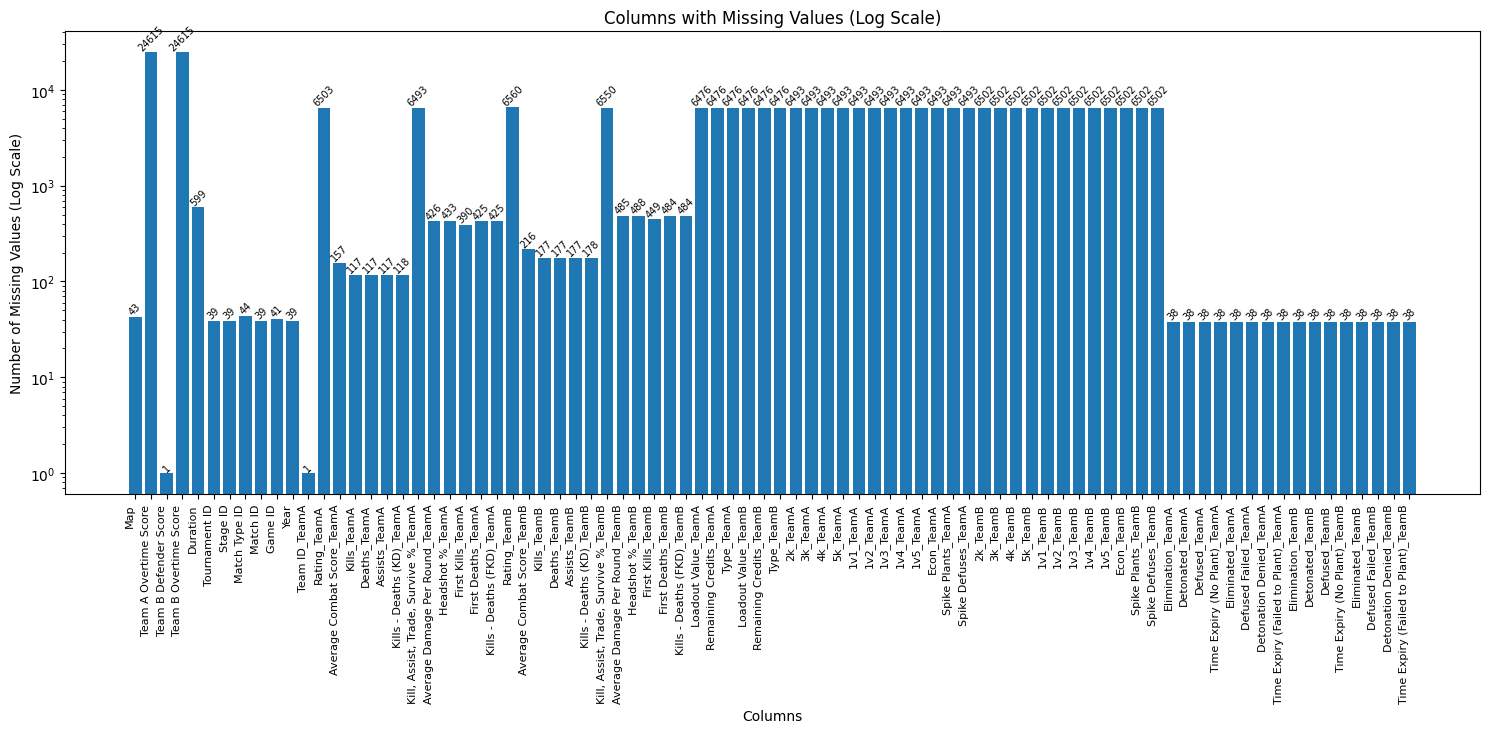

In [18]:
# Calculate missing values
missing_values = vct_2021_2024.isnull().sum()

# Filter to show only columns with missing values
missing_values = missing_values[missing_values > 0]


plt.figure(figsize=(15, 10))  # Increased figure size for better readability



# Use log scale for y-axis
plt.bar(range(len(missing_values)), missing_values.values)
plt.yscale('log')

plt.title('Columns with Missing Values (Log Scale)')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values (Log Scale)')

plt.xticks(range(len(missing_values)), missing_values.index, rotation=90, ha='right', fontsize=8)

# Add value labels on top of each bar
for i, v in enumerate(missing_values.values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=7, rotation=45)

# Adjust layout and margins
plt.tight_layout()
plt.subplots_adjust(bottom=0.5)

plt.show()

In [19]:
# Drop these missing values
vct_2021_2024 = vct_2021_2024.dropna(subset=["Map", 
                                             "Team B Defender Score", 
                                             "Tournament ID", 
                                             "Stage ID", 
                                             "Match Type ID", 
                                             "Match ID", 
                                             "Game ID", 
                                             "Team ID_TeamA", 
                                             "Team ID_TeamB"])

# Fill missing values with 0
cols_fill_zero = ["Team A Overtime Score", "Team B Overtime Score", "2k_TeamA", "3k_TeamA", "4k_TeamA", 
                  "5k_TeamA", "1v1_TeamA", "1v2_TeamA", "1v3_TeamA", "1v4_TeamA", "1v5_TeamA", "2k_TeamB", 
                  "3k_TeamB", "4k_TeamB", "5k_TeamB", "1v1_TeamB", "1v2_TeamB", "1v3_TeamB","1v4_TeamB", 
                  "1v5_TeamB", "Spike Plants_TeamA", "Spike Defuses_TeamA", "Spike Plants_TeamB",
                  "Spike Defuses_TeamB", "Elimination_TeamA", "Detonated_TeamA", "Defused_TeamA", 
                  "Time Expiry (No Plant)_TeamA", "Eliminated_TeamA","Defused Failed_TeamA",
                  "Detonation Denied_TeamA","Time Expiry (Failed to Plant)_TeamA", "Elimination_TeamB",
                  "Detonated_TeamB", "Defused_TeamB", "Time Expiry (No Plant)_TeamB","Eliminated_TeamB", 
                  "Defused Failed_TeamB", "Detonation Denied_TeamB","Time Expiry (Failed to Plant)_TeamB"]

vct_2021_2024[cols_fill_zero] = vct_2021_2024[cols_fill_zero].fillna(0)

# Fill missing values with the mean
cols_fill_mean = ["Rating_TeamA", "Average Combat Score_TeamA", "Kills_TeamA", "Deaths_TeamA", "Assists_TeamA",
                  "Kills - Deaths (KD)_TeamA", "Kill, Assist, Trade, Survive %_TeamA","Average Damage Per Round_TeamA", 
                  "Headshot %_TeamA","First Kills_TeamA", "First Deaths_TeamA", "Kills - Deaths (FKD)_TeamA",
                  "Rating_TeamB", "Average Combat Score_TeamB", "Kills_TeamB","Deaths_TeamB", "Assists_TeamB", 
                  "Kills - Deaths (KD)_TeamB","Kill, Assist, Trade, Survive %_TeamB","Average Damage Per Round_TeamB", 
                  "Headshot %_TeamB","First Kills_TeamB", "First Deaths_TeamB", "Kills - Deaths (FKD)_TeamB",
                  "Loadout Value_TeamA", "Remaining Credits_TeamA", "Loadout Value_TeamB", "Remaining Credits_TeamB", 
                  "Econ_TeamA", "Econ_TeamB"
]


vct_2021_2024[cols_fill_mean] = vct_2021_2024[cols_fill_mean].fillna(vct_2021_2024[cols_fill_mean].mean())

# Forward fill missing values
vct_2021_2024["Year"] = vct_2021_2024["Year"].ffill()


# Fill missing values with the most frequent value
cols_fill_mode = ["Duration", "Type_TeamA", "Type_TeamB"]

vct_2021_2024[cols_fill_mode] = vct_2021_2024[cols_fill_mode].fillna(vct_2021_2024[cols_fill_mode].mode().iloc[0])

vct_2021_2024.head()

,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team A Attacker Score,Team A Defender Score,Team A Overtime Score,...,Detonation Denied_TeamA,Time Expiry (Failed to Plant)_TeamA,Elimination_TeamB,Detonated_TeamB,Defused_TeamB,Time Expiry (No Plant)_TeamB,Eliminated_TeamB,Defused Failed_TeamB,Detonation Denied_TeamB,Time Expiry (Failed to Plant)_TeamB
0,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Haven,Vision Strikers,13,9,4,0.0,...,1.0,0.0,4.0,0.0,1.0,0.0,9.0,2.0,2.0,0.0
1,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Breeze,Vision Strikers,13,9,4,0.0,...,2.0,0.0,3.0,0.0,2.0,0.0,9.0,3.0,1.0,0.0
2,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Icebox,Team Vikings,13,6,7,0.0,...,5.0,1.0,2.0,1.0,5.0,1.0,7.0,2.0,3.0,1.0
3,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Haven,Team Vikings,13,6,7,0.0,...,1.0,0.0,5.0,2.0,1.0,0.0,11.0,0.0,2.0,0.0
4,Valorant Champions 2021,Group Stage,Opening (D),FNATIC vs Cloud9,Icebox,FNATIC,13,7,6,0.0,...,4.0,0.0,6.0,1.0,4.0,0.0,7.0,0.0,6.0,0.0


## Converting columns to their appropriate data type

In [20]:
convert_columns = ['Team A Overtime Score','Team B Defender Score','Team B Overtime Score','Tournament ID','Stage ID','Match Type ID',
                   'Match ID','Game ID','Team ID_TeamA','Team ID_TeamB','Year']

vct_2021_2024[convert_columns] = vct_2021_2024[convert_columns].astype('int32')


In [21]:
vct_2021_2024['Duration'] = pd.to_timedelta(vct_2021_2024['Duration'].apply(lambda x: '00:' + x if len(x.split(':')) == 2 else x)).dt.total_seconds() / 60
vct_2021_2024['Duration'].head(5)

0    59.183333
1    44.500000
2    59.800000
3    52.800000
4    59.833333
Name: Duration, dtype: float64

In [22]:
vct_2021_2024.dtypes

Tournament                               object
Stage                                    object
Match Type                               object
Match Name                               object
Map                                      object
Team A                                   object
Team A Score                              int64
Team A Attacker Score                     int64
Team A Defender Score                     int64
Team A Overtime Score                     int32
Team B                                   object
Team B Score                              int64
Team B Attacker Score                     int64
Team B Defender Score                     int32
Team B Overtime Score                     int32
Duration                                float64
Tournament ID                             int32
Stage ID                                  int32
Match Type ID                             int32
Match ID                                  int32
Game ID                                 

In [23]:
vct_2021_2024.head(5)

,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team A Attacker Score,Team A Defender Score,Team A Overtime Score,...,Detonation Denied_TeamA,Time Expiry (Failed to Plant)_TeamA,Elimination_TeamB,Detonated_TeamB,Defused_TeamB,Time Expiry (No Plant)_TeamB,Eliminated_TeamB,Defused Failed_TeamB,Detonation Denied_TeamB,Time Expiry (Failed to Plant)_TeamB
0,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Haven,Vision Strikers,13,9,4,0,...,1.0,0.0,4.0,0.0,1.0,0.0,9.0,2.0,2.0,0.0
1,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Breeze,Vision Strikers,13,9,4,0,...,2.0,0.0,3.0,0.0,2.0,0.0,9.0,3.0,1.0,0.0
2,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Icebox,Team Vikings,13,6,7,0,...,5.0,1.0,2.0,1.0,5.0,1.0,7.0,2.0,3.0,1.0
3,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Haven,Team Vikings,13,6,7,0,...,1.0,0.0,5.0,2.0,1.0,0.0,11.0,0.0,2.0,0.0
4,Valorant Champions 2021,Group Stage,Opening (D),FNATIC vs Cloud9,Icebox,FNATIC,13,7,6,0,...,4.0,0.0,6.0,1.0,4.0,0.0,7.0,0.0,6.0,0.0


## Feature engineering

In [24]:
def create_features(df):
    df["Score Diff"] = df["Team A Score"] - df["Team B Score"]

    df["ACS Diff"] = df["Average Combat Score_TeamA"] - df["Average Combat Score_TeamB"]

    df["KAST Diff"] = df["Kill, Assist, Trade, Survive %_TeamA"] - df["Kill, Assist, Trade, Survive %_TeamB"]

    df["ADR Diff"] = df["Average Damage Per Round_TeamA"] - df["Average Damage Per Round_TeamB"]

    for team in ["A", "B"]:
        # KDA per team
        df[f"Team {team} KDA"] = df[f"Kills_Team{team}"] + df[f"Assists_Team{team}"] / df[f"Deaths_Team{team}"]        

        # Clutch ratio
        clutch_situations = df[[f"1v1_Team{team}", f"1v2_Team{team}", f"1v3_Team{team}", f"1v4_Team{team}", f"1v5_Team{team}"]].sum(axis=1)
        df[f"Team {team} Clutch Win %"] = clutch_situations / df[f"Kills_Team{team}"]

        # First blood ratio
        df[f"Team {team} First Blood %"] = df[f"First Kills_Team{team}"] / (df[f"First Kills_Team{team}"] + df[f"First Deaths_Team{team}"])
    
    # Prediction target
    df["Winner"] = np.where(df["Team A Score"] > df["Team B Score"], "Team A", "Team B")

    return df


def map_win_perc(df):
    df["Team A Map Win %"] = df.groupby(["Team A", "Map"])["Winner"].transform(lambda x: np.mean(x == "Team A"))
    df["Team B Map Win %"] = df.groupby(["Team B", "Map"])["Winner"].transform(lambda x: np.mean(x == "Team B"))
    return df
    

def h2h_win_perc(df):
    df["Team A H2H Win %"] = df.groupby(["Team A", "Team B"])["Winner"].transform(lambda x: np.mean(x == "Team A"))
    df["Team B H2H Win %"] = df.groupby(["Team A", "Team B"])["Winner"].transform(lambda x: np.mean(x == "Team B"))
    return df

In [25]:
vct_2021_2024 = create_features(vct_2021_2024)
vct_2021_2024 = map_win_perc(vct_2021_2024)
vct_2021_2024 = h2h_win_perc(vct_2021_2024)

C:\Users\user\AppData\Local\Temp\ipykernel_13780\3158550281.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Team B H2H Win %"] = df.groupby(["Team A", "Team B"])["Winner"].transform(lambda x: np.mean(x == "Team B"))


In [26]:
# Drop single row with missing values
vct_2021_2024 = vct_2021_2024.dropna()

## Saving cleaned and preprocessed dataset

In [27]:
vct_2021_2024.to_csv("vct_data/vct_2021_2024.csv", index=False)
vct_2021_2024.head()

,Tournament,Stage,Match Type,Match Name,Map,Team A,Team A Score,Team A Attacker Score,Team A Defender Score,Team A Overtime Score,...,Team A Clutch Win %,Team A First Blood %,Team B KDA,Team B Clutch Win %,Team B First Blood %,Winner,Team A Map Win %,Team B Map Win %,Team A H2H Win %,Team B H2H Win %
0,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Haven,Vision Strikers,13,9,4,0,...,0.200000,0.555556,11.133333,0.092593,0.444444,Team A,0.904762,0.684211,1.000000,0.000000
1,Valorant Champions 2021,Group Stage,Opening (D),Vision Strikers vs FULL SENSE,Breeze,Vision Strikers,13,9,4,0,...,0.000000,0.666667,10.271429,0.000000,0.333333,Team A,0.666667,0.777778,1.000000,0.000000
2,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Icebox,Team Vikings,13,6,7,0,...,0.107527,0.590909,15.408602,0.266667,0.409091,Team A,0.692308,0.416667,1.000000,0.000000
3,Valorant Champions 2021,Group Stage,Opening (C),Team Vikings vs Crazy Raccoon,Haven,Team Vikings,13,6,7,0,...,0.178571,0.666667,12.240476,0.169492,0.333333,Team A,0.562500,0.611111,1.000000,0.000000
4,Valorant Champions 2021,Group Stage,Opening (D),FNATIC vs Cloud9,Icebox,FNATIC,13,7,6,0,...,0.000000,0.666667,14.951064,0.205479,0.333333,Team A,0.714286,0.470588,0.666667,0.333333


# Exploratory Data Analysis (EDA)

- Perform univariate and bivariate analysis
- Visualize trends and patterns (line, histogram, scatter, etc.)
- Analyze correlations between different features
- Document findings and form hypotheses about the factors influencing betting outcomes

### Univariate Analysis

In [169]:
import seaborn as sns

teamA = vct_2021_2024[['Team A', 'Kills_TeamA', 'Elimination_TeamA','Detonated_TeamA','Defused_TeamA','Time Expiry (Failed to Plant)_TeamA','Team A Attacker Score','Team A Defender Score','Average Combat Score_TeamA','Kill, Assist, Trade, Survive %_TeamA','Team A Clutch Win %','Headshot %_TeamA']].rename(columns={'Team A': 'Team', 'Kills_TeamA': 'Kills','Elimination_TeamA':'Elimination','Detonated_TeamA':'Detonated','Defused_TeamA':'Defused','Time Expiry (Failed to Plant)_TeamA':'Time Expiry','Team A Attacker Score':'Attacker Score','Team A Defender Score':'Defender Score','Average Combat Score_TeamA':'ACS','Kill, Assist, Trade, Survive %_TeamA':'KAST%','Team A Clutch Win %':'Clutch','Headshot %_TeamA':'Headshot%'})
teamB = vct_2021_2024[['Team B', 'Kills_TeamB', 'Elimination_TeamB','Detonated_TeamB','Defused_TeamB','Time Expiry (Failed to Plant)_TeamB','Team B Attacker Score','Team B Defender Score','Average Combat Score_TeamB','Kill, Assist, Trade, Survive %_TeamB','Team B Clutch Win %','Headshot %_TeamB']].rename(columns={'Team B': 'Team', 'Kills_TeamB': 'Kills','Elimination_TeamB':'Elimination','Detonated_TeamB':'Detonated','Defused_TeamB':'Defused','Time Expiry (Failed to Plant)_TeamB':'Time Expiry','Team B Attacker Score':'Attacker Score','Team B Defender Score':'Defender Score','Average Combat Score_TeamB':'ACS','Kill, Assist, Trade, Survive %_TeamB':'KAST%','Team B Clutch Win %':'Clutch','Headshot %_TeamB':'Headshot%'})
eda = pd.concat([teamA, teamB])

def plot_top_teams(data, column, title, xlabel):
    top_teams = data.groupby('Team')[column].mean().reset_index().sort_values(by=column, ascending=False).head(10)
    sns.barplot(x=column, y='Team', data=top_teams, palette='rocket', hue='Team', legend=False)
    plt.xlabel(xlabel)
    plt.ylabel('Team Name')
    plt.title(title)
    plt.show()

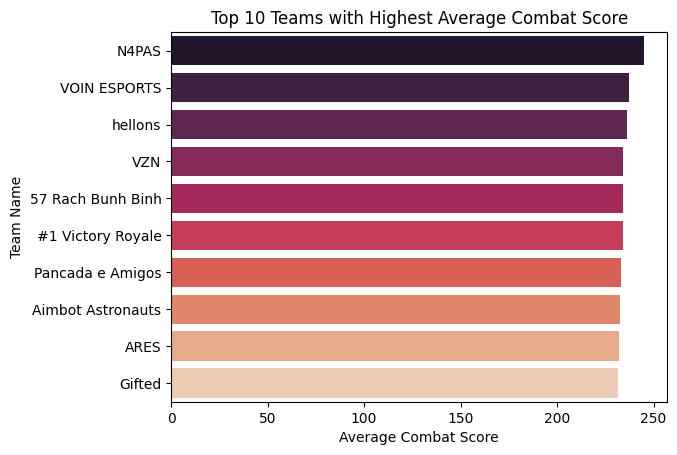

In [167]:
plot_top_teams(eda, 'ACS', 'Top 10 Teams with Highest Average Combat Score', 'Average Combat Score')

These are the teams that has the highest average combat score. The graph implies the players' skills in terms of damage and kills, which is a crucial factor in determining the winner of a match. Although N4PAS takes the lead, the average scores of the teams are relatively close to each other, showing only minor differences in performance.

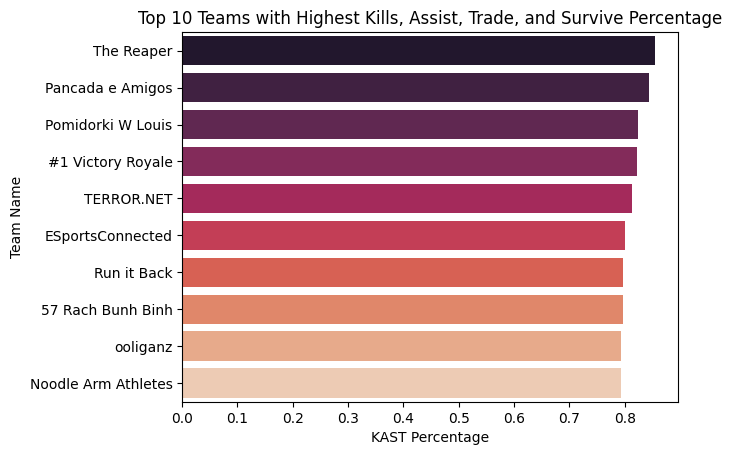

In [166]:
plot_top_teams(eda, 'KAST%', 'Top 10 Teams with Highest Kills, Assist, Trade, and Survive Percentage', 'KAST Percentage')

These are the teams with the highest KAST percentages, showing consistency in their performances. They excel in getting kills, assists, surviving, and trading effectively. The team with highest percentage exceeding 80%, is The Reaper. The teams have percentages that are closely aligned, indicating similar levels of performance.

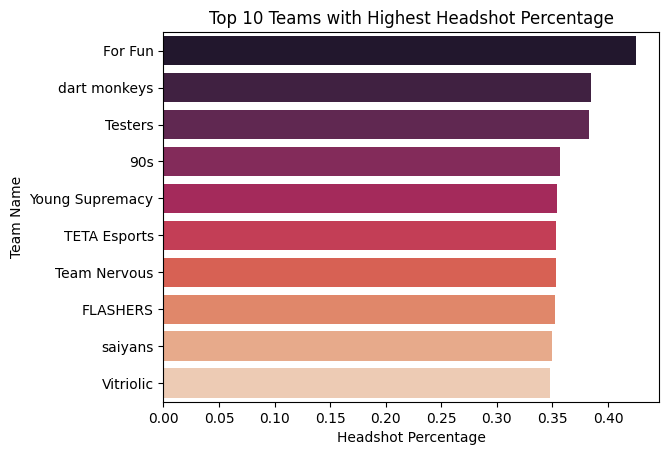

In [163]:
plot_top_teams(eda, 'Headshot%', 'Top 10 Teams with Highest Headshot Percentage', 'Headshot Percentage')

These teams demonstrated precise aiming skills, achieving more headshots than their competitors. The percentage of 30%-50% reflects their exceptional accuracy and effectiveness in securing eliminations. For Fun takes the lead with above 40% headshot percentage.

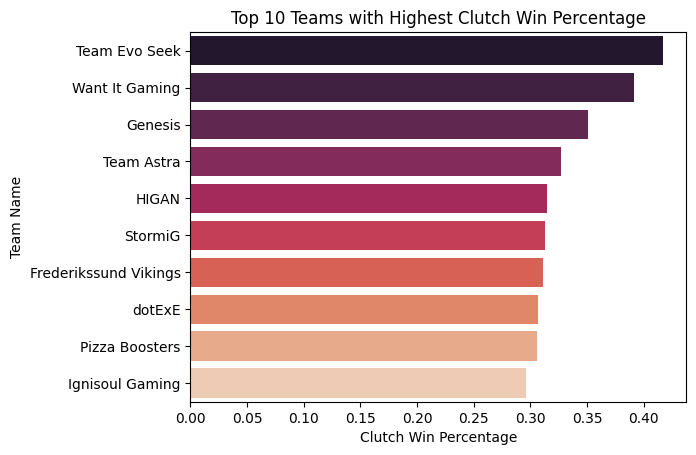

In [162]:
plot_top_teams(eda, 'Clutch', 'Top 10 Teams with Highest Clutch Win Percentage', 'Clutch Win Percentage')

These are the teams with the highest clutch win percentages, implying that they are great at winning tough rounds when the pressure is on. They show strong skills and teamwork, turning difficult situations into victories. Their ability to perform well in crucial moments is what helps them secure wins. Team Evo Seek has the highest clutch win percentage.

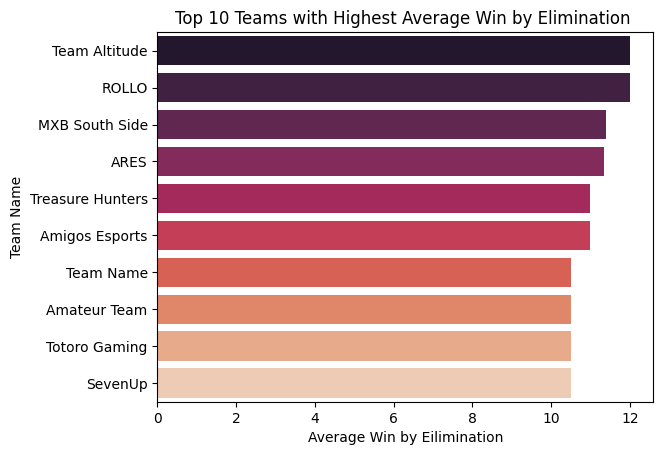

In [161]:
plot_top_teams(eda, 'Elimination', 'Top 10 Teams with Highest Average Win by Elimination ', 'Average Win by Eilimination')

The graph reveals that the teams with the highest average wins by elimination all have scores above 10, demonstrating their strong elimination skills. Leading teams are Team Altitude and Rollo.

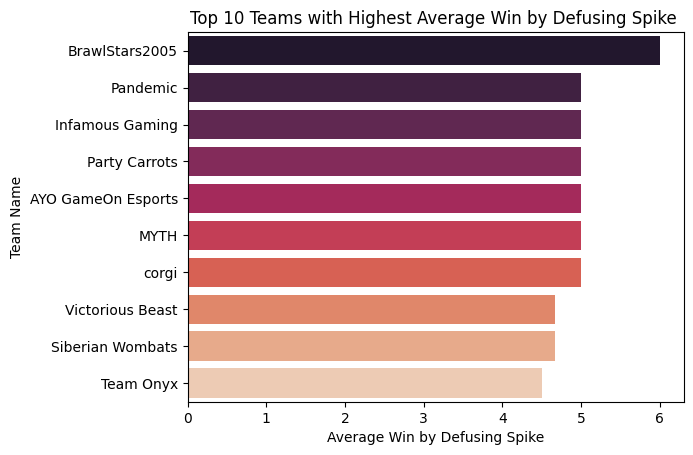

In [158]:
plot_top_teams(eda, 'Defused', 'Top 10 Teams with Highest Average Win by Defusing Spike ', 'Average Win by Defusing Spike')

Another crucial skill that can influence match outcomes is the ability to defuse the spike. Teams demonstrating proficiency in this area are BrawlStars2005, leading with an impressive average of 6 wins per map, game, and match.

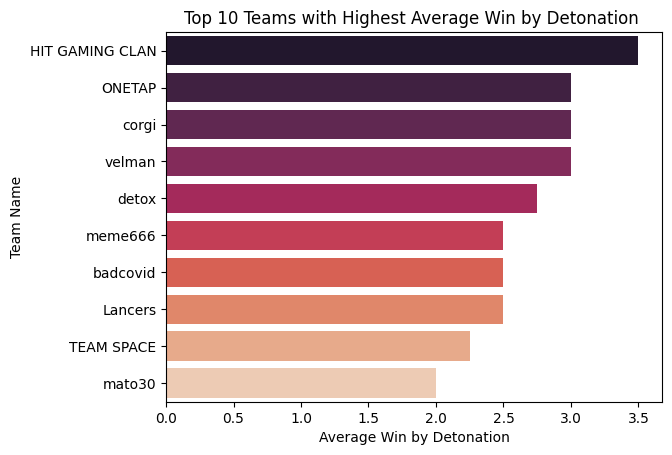

In [160]:
plot_top_teams(eda, 'Detonated', 'Top 10 Teams with Highest Average Win by Detonation ', 'Average Win by Detonation')

The graph indicates that these teams experienced the highest frequency of wins in detonating the spike. Hit Gaming Plan leads with a score of 3.5. The following teams' scores ranges from an average of 2 to 3 wins per map, game, and match.

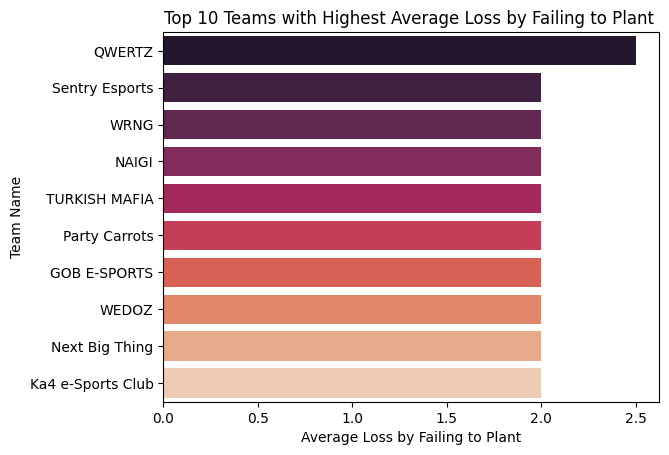

In [153]:
plot_top_teams(eda, 'Time Expiry', 'Top 10 Teams with Highest Average Loss by Failing to Plant ', 'Average Loss by Failing to Plant')

The graph suggests that these teams had the most frequent issues with spike planting, leading to higher losses. QWERTZ leads with a score of 2.5, and the following teams scored an average of 2 losses per map, game, and match.

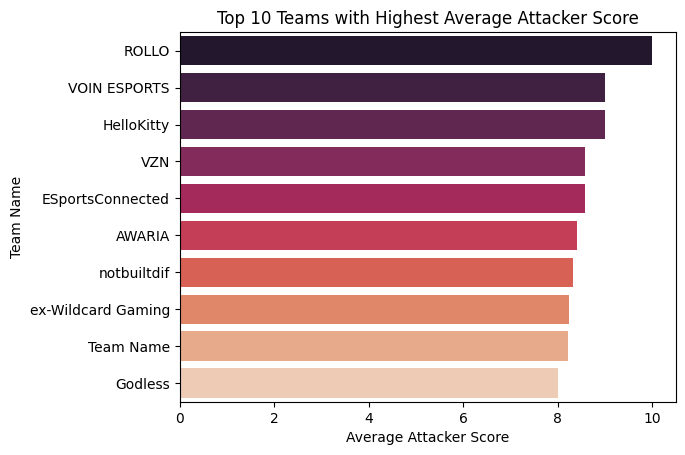

In [152]:
plot_top_teams(eda, 'Attacker Score', 'Top 10 Teams with Highest Average Attacker Score', 'Average Attacker Score')

The bar graph showcases the teams with the highest average attacker scores, reflecting their skills in attacking strategies. The leading teams have achieved average scores between 8 and 10 per map, game, and match, showing their effectiveness in gameplay.

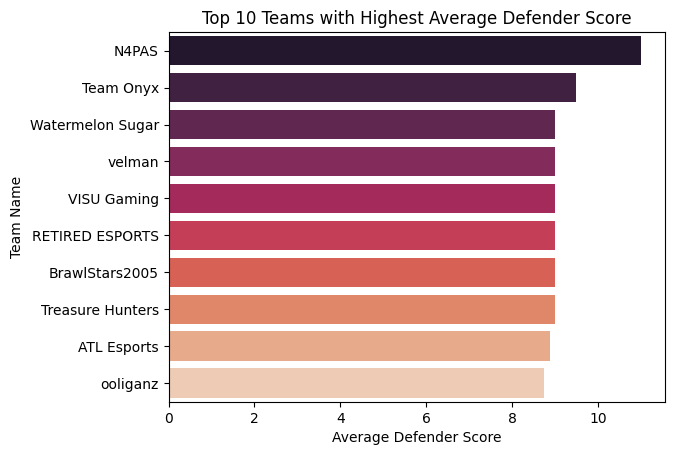

In [151]:
plot_top_teams(eda, 'Defender Score', 'Top 10 Teams with Highest Average Defender Score', 'Average Defender Score')

The bar graph illustrates the teams with the highest average defender scores, highlighting their effectiveness in defensive play and overall survivability. N4Pas is leading with Team Onyx.

Text(0.5, 1.0, 'Maps by Popularity')

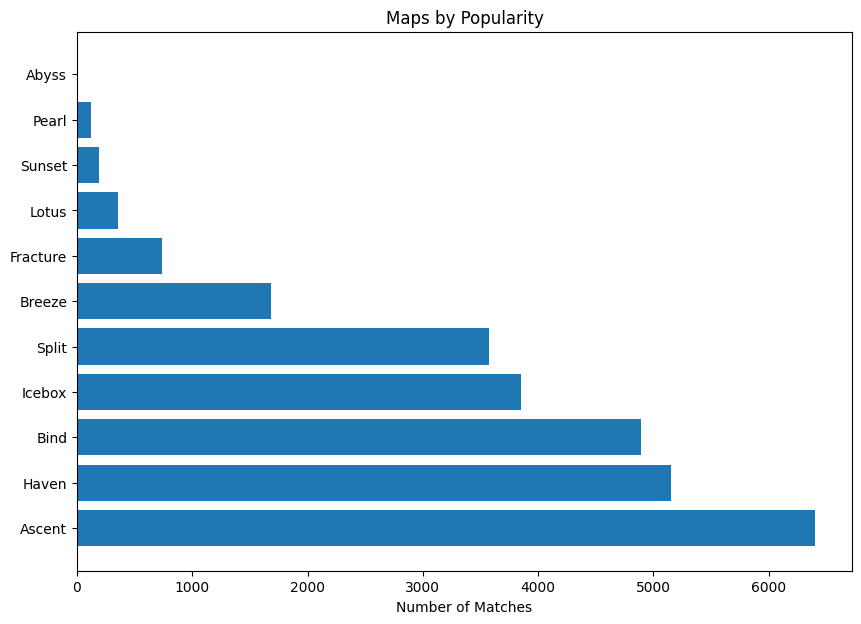

In [156]:
map_counts = vct_2021_2024['Map'].value_counts()

most_common_maps = map_counts.nlargest(11)

plt.figure(figsize=(10, 7))  
plt.barh(most_common_maps.index, most_common_maps.values)
plt.xlabel('Number of Matches') 
plt.title('Maps by Popularity')

The bar graph reveals that Ascent is the most popular map, followed by Haven, Bind, Icebox, and Split. These maps are preferred by players for their layouts. Conversely, Abyss is the least played, with Pearl, Sunset, Lotus, Fracture, and Breeze. This pattern suggests varying levels of player comfort and preference among the maps.

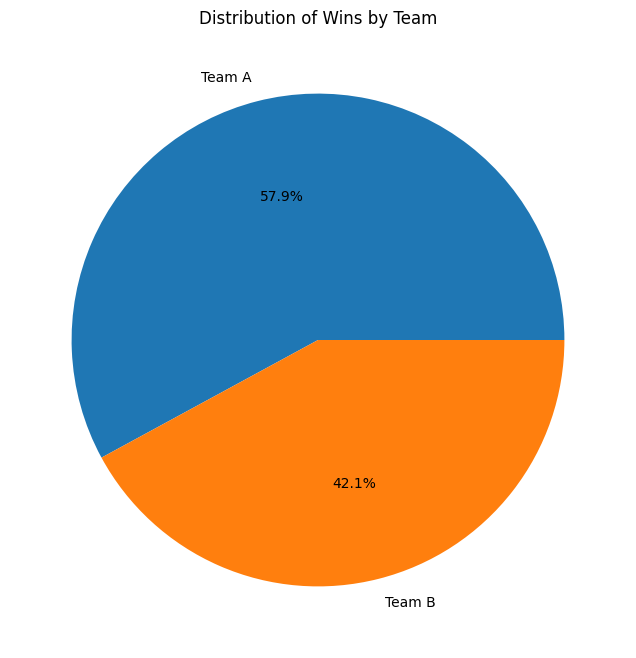

In [168]:
winner_counts = vct_2021_2024['Winner'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(winner_counts, labels=winner_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Wins by Team')
plt.show()

The pie chart illustrates the distribution of wins among the teams. This provides a clear comparison of their performance, where Team A shows a higher distribution of 59.7%.

# Encoding Categorical Data

In [28]:
categorical_columns = vct_2021_2024.select_dtypes(include=["object"]).columns
categorical_columns

Check cardinality of categorical columns

In [29]:
for col in categorical_columns:
    print(f"{col}: {vct_2021_2024[col].nunique()}")

In [30]:
# one hot encoding for columns Map, Type_TeamA, and Type_TeamB
dummies = pd.get_dummies(vct_2021_2024[['Map','Type_TeamA','Type_TeamB']]).fillna(0).astype('int16')

vct_2021_2024 = pd.concat([vct_2021_2024, dummies], axis=1)
vct_2021_2024.drop(['Map','Type_TeamA','Type_TeamB'], axis=1, inplace=True)

pd.set_option('display.max_columns', None)
vct_2021_2024.head(5)

# Model Selection and Training

- Will focus on predicting match outcomes, so models will be **Logistic Regression**, **Random Forest**, and **XGBoost**
- Perform hyperparamter tuning
- Consider ensemble methods or model stacking for improved accuracy

# Model Evaluation

- Evaluate model performance using the appropriate metrics
- Use cross-validation to assess the model's ability to generalize to new data
- Compare different models and select the one with the best trade-off between accuracy
and interpretability

# Model Validation

- Validate the model on unseen data, such as recent matches or a test dataset
- Analyze the model's predictions and compare them to actual outcomes
- Test the model's robustness by simulating different betting scenarios (e.g., low-risk vs.
high-risk bets)